In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer,AdamOptimizer,MomentumOptimizer
from sklearn.preprocessing import scale, normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
# %matplotlib qt

2022-01-31 10:33:05.584583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-31 10:33:05.584598: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# PCA on the dataset k > 2 
k=2
pca = PCA(n_components=k)

# Load the real distribution of a particular species
iris_fulldata = load_iris()
iris_dataset = iris_fulldata.data

# N = normalize
# iris_dataset = N(iris_dataset)
# print(iris_dataset)
print("Loading Iris Data....")
pca.fit(iris_dataset)
print("Mean = ", pca.mean_)

print("Variance Ratio = ", pca.explained_variance_ratio_)
print("Components = ", pca.components_)
X = pca.transform(iris_dataset)

species_value = 2 # Pick a number / species for the real distribution
print("Picking : Iris-",iris_fulldata['target_names'][species_value],"as real data distribution")
species_ind = [i for i, e in enumerate(iris_fulldata['target']) if e == species_value]

Loading Iris Data....
Mean =  [5.84333333 3.05733333 3.758      1.19933333]
Variance Ratio =  [0.92461872 0.05306648]
Components =  [[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]
Picking : Iris- virginica as real data distribution


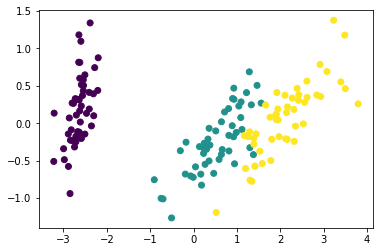

In [3]:
plt.scatter(X[:,0], X[:,1],c=iris_fulldata['target'])
plt.show()

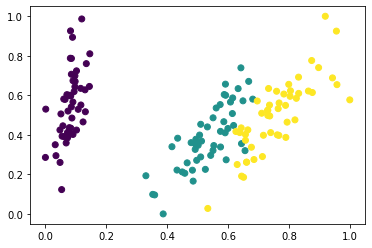

In [4]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
plt.scatter(X[:,0], X[:,1],c=iris_fulldata['target'])
plt.show()

In [5]:
# Extract relavant data from the dataset
x_in = X[species_ind[0]: species_ind[-1] + 1]
pca_data = 2*np.arcsin(np.sqrt(x_in)) 
# plt.scatter(X[:,0], X[:,1])
# plt.scatter(x_in[:,0], x_in[:,1])
# plt.show()
print(x_in)

[[0.8198644  0.47577926]
 [0.66088371 0.26174969]
 [0.83204246 0.60976941]
 [0.74013426 0.41143455]
 [0.79405229 0.46426022]
 [0.94321396 0.68814927]
 [0.53352277 0.02773056]
 [0.87704757 0.61416193]
 [0.78995266 0.38715414]
 [0.87479153 0.77600659]
 [0.69600588 0.57125824]
 [0.71618236 0.39783309]
 [0.76778041 0.56142813]
 [0.65104358 0.1852756 ]
 [0.68520077 0.27511098]
 [0.73057871 0.52467817]
 [0.73702262 0.49539657]
 [0.95603785 0.92484261]
 [1.         0.57697558]
 [0.64457985 0.19121042]
 [0.80513749 0.62275846]
 [0.63007862 0.24994152]
 [0.95787057 0.65399855]
 [0.6571128  0.4020898 ]
 [0.78342817 0.60639362]
 [0.83167412 0.69196146]
 [0.63855607 0.41144331]
 [0.64320372 0.4353194 ]
 [0.76179944 0.40007091]
 [0.7994654  0.65550063]
 [0.8640958  0.62164986]
 [0.91951338 1.        ]
 [0.76690368 0.39721192]
 [0.66500446 0.42518933]
 [0.71303295 0.29016287]
 [0.89754958 0.74013485]
 [0.76473907 0.53256167]
 [0.73067014 0.49818327]
 [0.62585111 0.4170167 ]
 [0.75952041 0.62052064]


In [6]:
x_not = np.concatenate((X[0:species_ind[0]],X[species_ind[len(species_ind)-1] + 1:len(X)]))
np.random.shuffle(x_not)
pca_not_data = 2*np.arcsin(np.sqrt(x_not)) 

In [7]:
dev = qml.device("default.qubit", wires= 2 * k + 1)
gen_dev = qml.device("default.qubit", wires=k)

In [8]:
def real(x_in_l):
#     qml.Rot(phi, theta, omega, wires=0)
    real_data_len = len(x_in_l)
    for i in range(real_data_len):
        qml.RY(x_in_l[i], wires= k + i)

In [9]:
def generator_sample(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires=h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
#         if i % 2 == 0:
        for l in range(1, len(W[i])):
            qml.CNOT(wires=[l-1, l])
            
def generator(w):
    W = np.reshape(w, (layers, k))
    for h in range(len(W[0])):
        qml.Hadamard(wires= k + h)
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires= k + j)
#         if i % 2 == 0:
        for l in range(1, len(W[i])):
            qml.CNOT(wires=[k+(l-1), k + l])

In [10]:
def discriminator(w):
    W = np.reshape(w, (layers, k))
    for i in range(layers):
        for j in range(len(W[i])):
            qml.RY(W[i][j], wires=j)
#         if i % 2 == 0:
        for l in range(1, len(W[i])):
            qml.CNOT(wires=[l-1, l])

In [11]:
# For real data set
@qml.qnode(dev,diff_method="parameter-shift")
def real_disc_circuit(x_in_l, disc_weights):
    qml.Hadamard(wires= 2 * k)
    discriminator(disc_weights)
    real(x_in_l)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# For Generated data set
@qml.qnode(dev,diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    qml.Hadamard(wires= 2 * k)
    generator(gen_weights)
    discriminator(disc_weights)
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
    return qml.expval(qml.PauliZ(2 * k))

# Exract Synthetic data from Generator:
gen_dev.shots = 20
@qml.qnode(gen_dev)
def gen_data(gen_weights):
    generator_sample(gen_weights)
    exp = [qml.sample(qml.PauliZ(i)) for i in range(k)]
    return exp

In [12]:
def prob_real_true(x_in_l, disc_weights):
    true_disc_output = real_disc_circuit(x_in_l, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true

# def prob_fakeReal_true(x_in_f, disc_weights):
#     fake_disc_output = real_disc_circuit(x_in_f, disc_weights)
#     # convert to probability
#     prob_fake_true = (fake_disc_output + 1) / 2
#     return prob_fake_true

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true  # generator wants to minimize this prob


def disc_cost(x_in_l, gen_weights, disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(x_in_l, disc_weights)
#     cost = -1 * (np.log(1 - prob_fake_true(gen_weights, disc_weights)) + np.log(prob_real_true(x_in_l, disc_weights)))
    return cost


def gen_cost(gen_weights, disc_weights):
#     return np.log(1 - prob_fake_true(gen_weights, disc_weights))
    return -prob_fake_true(gen_weights, disc_weights)

In [13]:
# np.random.seed(2)
layers = 4
eps = 1e-2
gen_weights = np.array([np.pi] + [0] * (layers * k - 1)) + np.random.normal(scale=eps, size=[layers * k])
disc_weights = np.random.normal(size=[k * layers])
drawer = qml.draw(real_disc_circuit, max_length=100)
print(drawer(x_in[0], disc_weights))

 0: ──RY(1.86)───╭C──RY(0.823)───╭C──RY(-0.0657)──╭C──RY(-0.93)──╭C──╭SWAP────────────┤    
 1: ──RY(0.251)──╰X──RY(-0.471)──╰X──RY(-0.971)───╰X──RY(-1.9)───╰X──│──────╭SWAP─────┤    
 2: ──RY(0.82)───────────────────────────────────────────────────────├SWAP──│─────────┤    
 3: ──RY(0.476)──────────────────────────────────────────────────────│──────├SWAP─────┤    
 4: ──H──────────────────────────────────────────────────────────────╰C─────╰C─────H──┤ ⟨Z⟩



In [14]:
drawer = qml.draw(gen_disc_circuit, max_length=100)
print(drawer(gen_weights, disc_weights))

 0: ──RY(1.86)───╭C────────────RY(0.823)───╭C──────────────RY(-0.0657)──╭C─────────────RY(-0.93)──╭
 1: ──RY(0.251)──╰X────────────RY(-0.471)──╰X──────────────RY(-0.971)───╰X─────────────RY(-1.9)───╰
 2: ──H───────────RY(3.14)────╭C────────────RY(0.000845)──╭C─────────────RY(0.0107)───╭C───────────
 3: ──H───────────RY(-0.012)──╰X────────────RY(-0.00346)──╰X─────────────RY(0.00265)──╰X───────────
 4: ──H────────────────────────────────────────────────────────────────────────────────────────────

 C─────────────────╭SWAP────────────┤    
 X─────────────────│──────╭SWAP─────┤    
 RY(0.00944)───╭C──├SWAP──│─────────┤    
 RY(-0.00044)──╰X──│──────├SWAP─────┤    
 ──────────────────╰C─────╰C─────H──┤ ⟨Z⟩



In [15]:
opt = MomentumOptimizer(0.01)

Starting Epoch :  0
Step 1: cost = -0.026502769680643024
Step 11: cost = -0.14222911996143373
Step 21: cost = -0.3804117138859412
Step 31: cost = -0.4405214550936669
Step 41: cost = -0.47330016311595735
Checking output : P(Real == True) : 0.9670778514328446
Checking output : P(Gen == True) : 0.5032161841861434
Generator Training starting......
Step 1: cost = -0.5032804036757321
Step 11: cost = -0.5075234360170042
Step 21: cost = -0.5245543467463021
Step 31: cost = -0.579153014665407
Step 41: cost = -0.7174008273895063
Step 51: cost = -0.9123409408463528
Step 61: cost = -0.9979055133699899
Step 71: cost = -0.9949423886721733
Step 81: cost = -0.9951525795231277
Step 91: cost = -0.9992279741352196
Checking output : P(Real == True) : 0.9670778514328446
Checking output : P(Gen == True) : 0.9999971620185677
Disc Cost =  0.03291931058572306


NameError: name 'valid_labels' is not defined

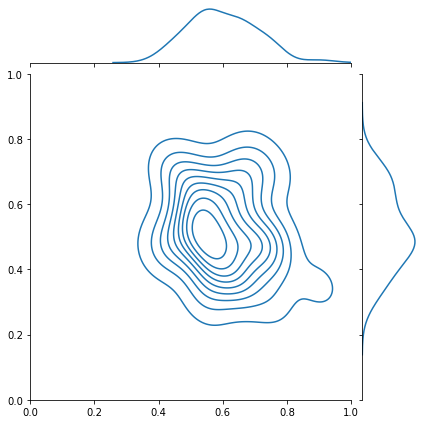

In [16]:
# trainin cycle loop:
# dev.shots = 10
# learning_rate = 0.1
epochs = 100
for ep in range(epochs):
    print("Starting Epoch : ", ep)
    
    # Train the discriminator first, lock the generator variables:
    disc_weights.requires_grad = True
    gen_weights.requires_grad = False
    for i in range(len(pca_data)):
        x_in_l = np.array(pca_data[i], requires_grad=False)
        x_in_l, gen_weights, disc_weights = opt.step(disc_cost, x_in_l, gen_weights, disc_weights)
        cost = disc_cost(x_in_l,gen_weights, disc_weights)
        if i % 10 == 0:
            print("Step {}: cost = {}".format(i + 1, cost))
            
    test_x = pca_data[random.randrange(len(pca_data))]
    print("Checking output : P(Real == True) :", prob_real_true(test_x, disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    
    print("Generator Training starting......")
    # Train the Generator next, lock the discriminator variables:
    disc_weights.requires_grad = False
    gen_weights.requires_grad = True   
    for j in range(100):
        gen_weights, disc_weights = opt.step(gen_cost, gen_weights, disc_weights)
#         gradient = qml.gradients.param_shift(gen_disc_circuit)(gen_weights, disc_weights)
#         gen_weights = update_weights(gen_weights, learning_rate, gradient, True)
        cost = gen_cost(gen_weights, disc_weights)
        if j % 10 == 0:
            print("Step {}: cost = {}".format(j + 1, cost))
            
    print("Checking output : P(Real == True) :", prob_real_true(test_x, disc_weights))
    print("Checking output : P(Gen == True) :", prob_fake_true(gen_weights, disc_weights))
    print("Disc Cost = ", disc_cost(test_x, gen_weights,disc_weights))
    # generate distribution graph
    gen_datas = []
    for _ in range(50):
        res = gen_data(gen_weights)
        result = []
        for i in range(len(res)): 
            result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
        gen_datas.append(result)
    
    generated_data = np.array(gen_datas)
    graph = sns.jointplot(x=generated_data[:,0],y=generated_data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
    graph.x = X[:,0]
    graph.y = X[:,1]
    graph.plot_joint(plt.scatter, marker='o', c=iris_fulldata['target'], s=5)
    plt.show()

In [ ]:
# Exract Synthetic data from Generator:
gen_dev.shots= 20
gen_datas = []
for _ in range(50):
    res = gen_data(gen_weights)
    result = []
    for i in range(len(res)): 
        result.append(res[i].tolist().count(-1) / len(res[i].tolist()))
    print(result)
    gen_datas.append(result)

In [ ]:
synthetic_points = scaler.inverse_transform(np.array(gen_datas))
synthetic_points = pca.inverse_transform(synthetic_points)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
syn_x = synthetic_points[:, :2]
syn_y = [species_value for _ in range(len(syn_x))]
x = iris_fulldata.data[:, :2]
y = iris_fulldata.target

In [ ]:
x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
plt.figure(2, figsize=(8, 6))
plt.clf()

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.scatter(syn_x[:, 0], syn_x[:, 1], c=syn_y, cmap=plt.cm.Set2, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

#### CSwap Test for real and generated data

In [ ]:
test_dev = qml.device("default.qubit", wires=2 * k + 1)

def real(x_in_l):
#     qml.Rot(phi, theta, omega, wires=0)
    real_data_len = len(x_in_l)
    for i in range(real_data_len):
        qml.RY(x_in_l[i], wires=i)
        
@qml.qnode(test_dev)
def cswap_test(x_in_l, gen_weights):
    qml.Hadamard(wires= 2 * k)
        
    generator(gen_weights)
    real(x_in_l)
    
    for j in range(k):
        qml.CSWAP(wires=[ 2 * k, j, k + j])
    qml.Hadamard(2 * k)
        
    return qml.probs(wires= 2 * k)

In [ ]:
drawer = qml.draw(cswap_test,max_length=100)
print(drawer(x_in[0], gen_weights))

In [ ]:
test_dev.shots = 2048
avg_fid = 0
for rot_data in pca_data:
    avg_fid += cswap_test(rot_data, gen_weights)
print("Avg_Fidelity : ", avg_fid / len(pca_data))

In [ ]:
import seaborn as sns
generated_data = np.array(gen_datas)
graph = sns.jointplot(x=generated_data[:,0],y=generated_data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
graph.x = X[:,0]
graph.y = X[:,1]
graph.plot_joint(plt.scatter, marker='o', c=y, s=5)
plt.show()